In [63]:
import matplotlib.pyplot as plt
import micromagneticmodel as mm
import numpy as np


import custom_physics_equations as cpe
from custom_helper_files import colour_palettes as color_palette, custom_dispersion_relations as cdr

cpalette = color_palette.ColorPalette()

import matplotlib.patches as patches
from scipy.interpolate import interp1d

In [64]:
# Physical constants
gamma = 28.2e9 * 2 * np.pi  # Gyromagnetic ratio [m/(A·s)]
gamma_mu0 = gamma * mm.consts.mu0   # [T·s/m]

In [65]:
# Material parameters
L_dim = [8804e-9, 1e-9, 12e-9]
delta_x = 1e-9  # lattice spacing

M_s = 8e5  # Saturation magnetization [A/m]
A = 1.3e-11  # Exchange stiffness [J/m]
D = 1e-3  # DMI constant [J/m^2]

K_1 = 0*6.2e4      # Uniaxial anisotropy constant [J/m^3]
K_2 = 0      # Uniaxial anisotropy constant [J/m^3]
a_axis = [0, 0, 1]      # Uniaxial anisotropy constant [J/m^3]

alpha = 0.0001  # Damping constant

# External field along z [T]
H_0 = 0.15

# Driving field [T]
h0_x = 1e-3
h0_d = 120e-9

# Driving frequency [GHz]
f_pump = 22.1

use_fft_drive = True

In [66]:
# Conversions to [A/m]
h0_x /= mm.consts.mu0
H_0 /= mm.consts.mu0

# Demagnetizing factors for thin film
demag_factors = cpe.calculate_demag_factor_uniform_prism(L_dim[0], L_dim[1], L_dim[2])
use_demag = True
N_x = demag_factors['N_x'] if use_demag is True else 0
N_y = demag_factors['N_y'] if use_demag is True else 0
N_z = demag_factors['N_z'] if use_demag is True else 0

#print(demag_factors)
# demag_factor: {'N_x': 0.000134011335297314, 'N_y': 0.8941829035248666, 'N_z': 0.1056830862869448} when L_dim: [8.8e-06, 1e-09, 1.2e-08]


In [67]:
# Wavevector array
kmax = 0.8 * 1e9  # [rad/m]
num_k_points = int(round((L_dim[0] / delta_x)))
k_array = np.linspace(-kmax, kmax, num_k_points)  # [rad/m]

k_lim_max = 0.12  # [1/nm]
k_array_lim = [-k_lim_max, k_lim_max]
omega_lim = [0, 25]

In [68]:
# Effective fields
H_ex = (2 * A / (mm.consts.mu0 * M_s)) * k_array**2  # Exchange field [A/m]
H_DMI = - (2 * D / (mm.consts.mu0 * M_s)) * k_array    # DMI field. Negative is simply to match convention of my C++ code
H_ani = (2 * a_axis[2]**2) / (M_s * mm.consts.mu0) * (K_1 + 2 * K_2 * a_axis[2]**2)  # Anisotropy field

# Total effective fields
H_eff_x = H_0 + H_ex + H_ani + M_s * (N_y - N_z)
H_eff_y = H_0 + H_ex + H_ani + M_s * (N_x - N_z)

# Frequencies from dispersion relation
omega_k = np.sqrt(H_eff_x * H_eff_y)
omega_k += H_DMI
omega_k *= gamma_mu0

# Include damping in the frequency
Omega = omega_k - 1j * alpha * omega_k

In [69]:
# Compute L components
L_xx = 1j * Omega - gamma_mu0 * H_eff_x
L_yy = 1j * Omega - gamma_mu0 * H_eff_y
L_xy = gamma_mu0 * H_DMI
L_yx = -L_xy


In [70]:
# Determinant
det_L = L_xx * L_yy - L_xy * L_yx

In [71]:
# Dynamic susceptibility components
chi_xx =   gamma_mu0 * M_s * (L_yy / det_L)
chi_yx = - gamma_mu0 * M_s * (L_yx / det_L)

In [72]:
# Incorporate the spatial profile of the pumping field h0(k)
# Assuming h0(x) is uniform within the driving region of width h0_d

# Fourier transform of h0(x)
# h0(k) = h0 * d * sinc(k * d / 2) * exp(-i * k * x0)

#x0 = L_dim[0] / 2  # Center of the driving region [m]

# Compute h0(k)
#sinc_arg = k_array * h0_d / 2
use_fancy_fft = False
if use_fancy_fft:
    # Define the spatial domain
    num_x_points = len(k_array)
    x_array = np.linspace(0, L_dim[0], num_x_points)
    delta_x = x_array[1] - x_array[0]  # Spatial sampling interval

    # Define h0(x)
    h0_x_array = np.zeros_like(x_array)  # Units: A/m

    # Driving region centered at x0
    x0 = L_dim[0] / 2
    half_width = h0_d / 2
    drive_indices = np.where(np.abs(x_array - x0) <= half_width)[0]

    # Assign h0_x within the driving region
    h0_x_array[drive_indices] = h0_x  # Units: A/m

    # Compute the FFT
    h0_k = np.fft.fft(h0_x_array) * delta_x  # Multiply by delta_x for correct scaling

    # Corresponding k-values
    k_array_fft = np.fft.fftfreq(num_x_points, d=delta_x) * 2 * np.pi  # Convert to rad/m

    # Shift the zero frequency component to the center
    h0_k = np.fft.fftshift(h0_k)
    k_array_fft = np.fft.fftshift(k_array_fft)

    # Normalize by the total length L to maintain units of A/m
    h0_k = h0_k / L_dim[0]

    # Interpolate h0_k onto k_array
    h0_k_interp_func = interp1d(k_array_fft, h0_k, kind='linear', fill_value=0, bounds_error=False)
    h0_k_interp = h0_k_interp_func(k_array)
    #h0_k = h0_x * np.sinc(sinc_arg / np.pi) * np.exp(-1j * k_array * x0)
    h0_k = h0_k_interp * (2 * np.pi)

if use_fft_drive:
    x0 = L_dim[0] / 2  # Center of the driving region [m]

    # Compute h0(k)
    sinc_arg = (1 * (h0_d / 2) * k_array )
    h0_k = h0_x * np.sinc(sinc_arg / np.pi) * np.exp(-1j * k_array * x0)
    #h0_k = np.sin(sinc_arg / 1) * np.exp(-1j * k_array * x0)

else:
    h0_k = h0_x  # Assuming h0_x is constant


In [73]:
# Compute m_x and m_y for each k
fancy_chi = False
if fancy_chi:
    # Compute the coupling coefficient C(k)
    k_array_nonzero = np.copy(k_array)
    k_array_nonzero[k_array_nonzero == 0] = 1e-12  # Avoid division by zero

    C_k = h0_x * 2 * np.sin(k_array * h0_d / 2) / k_array_nonzero * np.exp(-1j * k_array * h0_d)

    # Handle k = 0 case
    idx_k0 = np.where(np.abs(k_array) < 1e-12)[0]
    if idx_k0.size > 0:
        C_k[idx_k0] = h0_x * h0_d

    # Compute m_x and m_y at omega_pump
    omega_pump_rad_s = 2 * np.pi * f_pump * 1e9  # Convert GHz to rad/s
    Omega_pump = omega_pump_rad_s - 1j * alpha * omega_pump_rad_s

    # Recalculate L components at omega_pump
    L_xx_pump = -1j * Omega_pump - gamma_mu0 * H_eff_x
    L_yy_pump = -1j * Omega_pump - gamma_mu0 * H_eff_y
    L_xy_pump = gamma_mu0 * H_DMI
    L_yx_pump = -L_xy_pump

    det_L_pump = L_xx_pump * L_yy_pump - L_xy_pump * L_yx_pump

    chi_xx_pump = gamma_mu0 * M_s * L_yy_pump / det_L_pump
    chi_yx_pump = -gamma_mu0 * M_s * L_yx_pump / det_L_pump

    # Compute m_x and m_y
    m_x = -chi_xx_pump * C_k #/ mm.consts.mu0
    m_y = -chi_yx_pump * C_k #/ mm.consts.mu0
    m_z = np.zeros_like(m_x) * h0_k
else:
    m_x = -chi_xx * h0_k
    m_y = -chi_yx * h0_k
    m_z = np.zeros_like(m_x) * h0_k


In [74]:
# Compute excitation amplitude
excitation_amplitude_mx = np.abs(m_x)
excitation_amplitude_my = np.abs(m_y)

# Compute total excitation amplitude
excitation_total = np.sqrt(np.abs(m_x)**2 + np.abs(m_y)**2)

In [75]:
# Compute phases
phase_mx = np.angle(m_x)
phase_my = np.angle(m_y)
delta_phi = np.unwrap(phase_my - phase_mx)

In [76]:
# Compute group velocity
v_g = np.gradient(omega_k, k_array)  # [rad/s per rad/m] = [m/s]
v_g = v_g.real  # Take the real part

In [77]:
# Compute Poynting vector S_x
dmx_dx = 1j * k_array * m_x
dmy_dx = 1j * k_array * m_y
dmz_dx = 1j * k_array * m_z

S_x = (gamma / 2) * mm.consts.mu0 * M_s**2 * np.imag(np.conj(m_x) * dmy_dx - np.conj(m_y) * dmx_dx)
S_y = (gamma / 2) * mm.consts.mu0 * M_s**2 * np.imag(np.conj(m_z) * dmx_dx - np.conj(m_x) * dmz_dx)

In [78]:
# Convert units for plotting
k_array_nm = k_array * 1e-9  # [1/nm]
omega_GHz = omega_k / (2 * np.pi * 1e9)  # [GHz]
v_g_km_s = v_g * 1e-3  # [km/s]

In [79]:
# Separate positive and negative k values
pos_k_indices = k_array >= 0.0
neg_k_indices = k_array < 0.0

def sort_arrays(arrays, key_array):
    sorted_indices = np.argsort(key_array)
    return [array[sorted_indices] for array in arrays]

# Positive k values
omega_pos, excitation_mx_pos, excitation_my_pos, delta_phi_pos, v_g_pos = sort_arrays(
    [omega_GHz[pos_k_indices], excitation_amplitude_mx[pos_k_indices], excitation_amplitude_my[pos_k_indices],
     delta_phi[pos_k_indices], v_g_km_s[pos_k_indices]], omega_GHz[pos_k_indices])

# Negative k values
omega_neg, excitation_mx_neg, excitation_my_neg, delta_phi_neg, v_g_neg = sort_arrays(
    [omega_GHz[neg_k_indices], excitation_amplitude_mx[neg_k_indices], excitation_amplitude_my[neg_k_indices],
     delta_phi[neg_k_indices], v_g_km_s[neg_k_indices]], omega_GHz[neg_k_indices])

In [80]:
# For positive and negative k
excitation_total_pos = excitation_total[pos_k_indices]
excitation_total_neg = excitation_total[neg_k_indices]

In [81]:
# Spectral Density Function
# Compute S(k, omega) = |chi(k, omega)|^2

# Since we have a single frequency (omega_pump), we can compute S(k) at omega_pump

# Interpolate chi_xx and chi_yx at omega_pump
# Here, we assume omega_pump is within the range of omega_k

# Find indices close to omega_pump
omega_diff = np.abs(omega_GHz - f_pump)
indices_pump = np.where(omega_diff == np.min(omega_diff))[0]

# Extract chi_xx and chi_yx at omega_pump
chi_xx_pump = chi_xx[indices_pump]
chi_yx_pump = chi_yx[indices_pump]

# Compute spectral density
S_xx = np.abs(chi_xx_pump)**2
S_yx = np.abs(chi_yx_pump)**2

In [82]:
# Interpolation functions
common_freq = np.linspace(max(min(omega_pos), min(omega_neg)), min(max(omega_pos), max(omega_neg)), 500)
interp_mx_pos = interp1d(omega_pos, excitation_mx_pos, kind='linear', fill_value='extrapolate')
interp_mx_neg = interp1d(omega_neg, excitation_mx_neg, kind='linear', fill_value='extrapolate')
interp_my_pos = interp1d(omega_pos, excitation_my_pos, kind='linear', fill_value='extrapolate')
interp_my_neg = interp1d(omega_neg, excitation_my_neg, kind='linear', fill_value='extrapolate')

# Interpolated values
mx_pos_interp = interp_mx_pos(common_freq)
mx_neg_interp = interp_mx_neg(common_freq)
my_pos_interp = interp_my_pos(common_freq)
my_neg_interp = interp_my_neg(common_freq)

# Calculate asymmetry ratios
asymmetry_ratio_mx = mx_pos_interp / mx_neg_interp
asymmetry_ratio_my = my_pos_interp / my_neg_interp

# Handle divisions by zero
asymmetry_ratio_mx[np.abs(mx_neg_interp) < 1e-12] = np.nan
asymmetry_ratio_my[np.abs(my_neg_interp) < 1e-12] = np.nan

In [83]:

# Determine the threshold frequency
freq_min_index = np.argmin(excitation_amplitude_my)
threshold_freq = omega_GHz[freq_min_index]

# Filter the data based on the condition
filtered_omega_pos = omega_pos[omega_pos > threshold_freq]
filtered_ratio_mx = (excitation_mx_pos / excitation_mx_neg)[omega_pos > threshold_freq]
filtered_ratio_my = (excitation_my_pos / excitation_my_neg)[omega_pos > threshold_freq]

In [84]:
freq_lines_arr_pos = np.array([ -9.1 , 12.1,  16.2 , -17.66, 22.1 , 23.4 , -29.5 , 37.  , 38.6 ,
       -47.  , 56.  , 59.  ])
freq_lines_arr_neg = np.array([ 9.1 , -12.1,  16.2 , 17.66, 22.1 , -23.4 , 29.5 , 37.  , -38.6 ,
       47.  , 56.  , -59.  ])
freq_lines_arr_bal = np.array([-10.08, 7.82, 25.45, -33.34# 10.7, 14, 21, 35, 42, 54
                                ])

k_lines_arr = [ -0.04, 0.04, -0.14, 0.14]
#k_lines_arr = np.array([ 0.0517, -0.0334,  0.0736, -0.0522,  0.0978, -0.0734,  0.1053,
#       -0.0802,  0.1261, -0.0993,  0.1317, -0.1046,  0.1554, -0.1271,
#        0.1807, -0.1516,  0.1857, -0.1564,  0.2099, -0.1802,  0.2331,
#       -0.2031,  0.2404, -0.2103])

In [85]:
freq_lines_arr_pos = np.array([
    #12, 16, 22, 30, 37, 47, 55

])
freq_lines_arr_neg = np.array([
    #12, 17.5, 23.5, 30, 39.5, 47, 59
])

freq_lines_arr_bal = np.array([7.82, 10.5, 14.6, 20.9, 26.3, 34.8, 42, 53.7])

k_lines_arr = [
            0.04000, -0.02350,
            0.05960, -0.04020,
            0.09010, -0.06650,
            0.12120, -0.09480,
            0.14060,  -0.11300,
            0.17425, -0.14530,
            0.19290,  -0.16350,
            0.22570,  -0.19570,
]

In [86]:
freq_lines_arr_pos = np.array([
   # 7, -9, 13, -17.5, 22.5, -30, 37, -47, 56
    #7.82, 25.45, 15.4
    #17.6, 0
])

freq_lines_arr_neg = np.array([
    #-7, 10.5, -14.5, 21, -28, 35.5, -43.5, 55, -67
    #10.08, 33.34, 36.6
    #22.5, 30
])

freq_lines_arr_bal = np.array([
           #13, 39
    9.3, 12, 14, 18
])

k_lines_arr = [ #-0.04, 0.059, # 10
                #-0.14, 0.169, # 33
                #0.04, -0.024, # 7.8
                #0.14, -0.113, # 25.45
                #0.18, -0.15, # 36.6
                #0.094, -0.74, # 15.4

                #0.13, 0.124, #?
                #-0.103, 0.158
                #0.13, -0.13,
               #-0.103, 0.103, #original
               #0.129, # match -0.103
               #0.079, #match 0.103

               #-0.129,0.157,

               #0.079, -0.157,

               # -0.04, 0.04
]

/var/folders/5k/w2x2jdc132zgbnmr5xr2x4n40000gn/T/ipykernel_36882/465912900.py:131: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig_1_axes['disp-rel'].legend(title='Frequency, $f$ (GHz)', title_fontsize=12, fontsize=10)


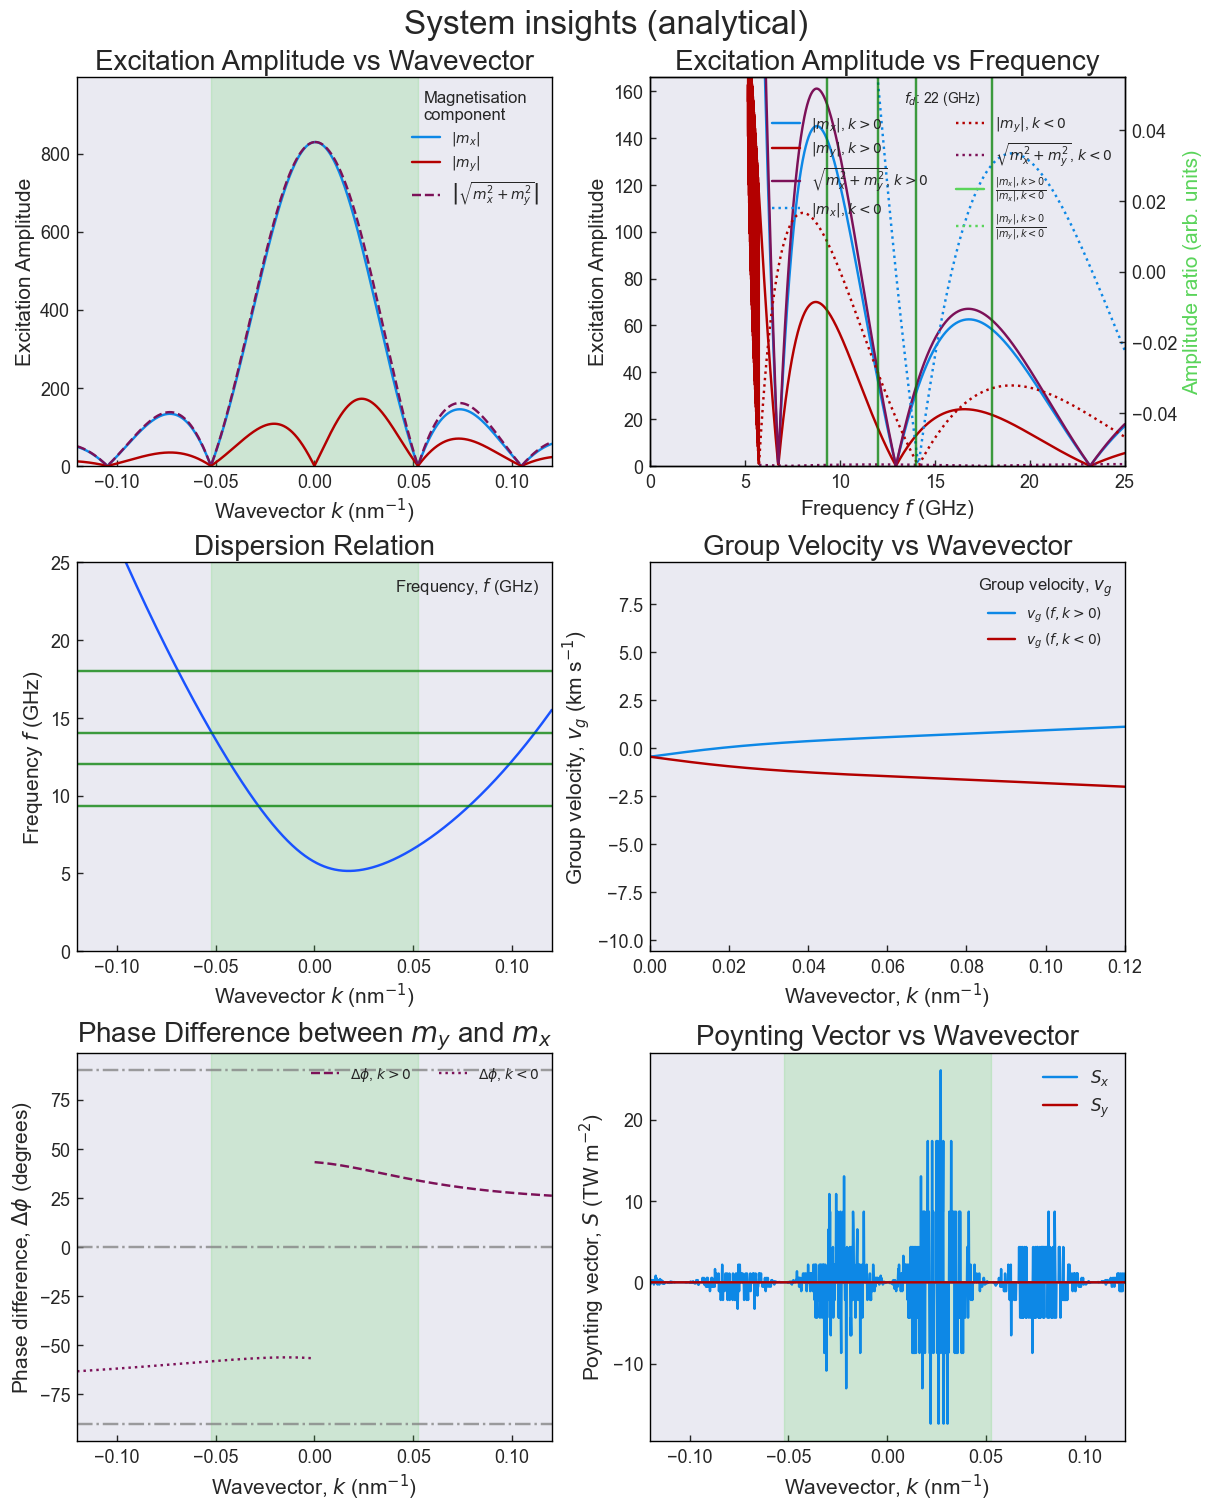

In [87]:

fig_1, fig_1_axes = plt.subplot_mosaic(mosaic=[['excitation-k', 'excitation-freq'],
                                          ['disp-rel', 'velocity-k'],
                                               ['phase-diff', 'poynting-vec']],
                                  figsize=(12, 15),
                                  gridspec_kw={'width_ratios': (1, 1),
                                               'height_ratios': (1, 1, 1),
                                               'wspace': 0.0,
                                               'hspace': 0.0},
                                  layout='constrained',
                                  facecolor='white',
                                  )
fig_1.suptitle('System insights (analytical)', fontsize=24)

cpalette.load_palette(name="river_nights")

# Excitation amplitude vs Wavevector
fig_1_axes['excitation-k'].plot(k_array_nm, excitation_amplitude_mx, label=r'$|m_x|$', color=cpalette.use('blue'))
fig_1_axes['excitation-k'].plot(k_array_nm, excitation_amplitude_my, label=r'$|m_y|$', color=cpalette.use('red'))

fig_1_axes['excitation-k'].plot(k_array_nm[pos_k_indices], excitation_total_pos, label=r'$\left| \sqrt{m_x^2 + m_y^2} \right|$',
                                color=cpalette.use('darkpurple'), linestyle='--')
fig_1_axes['excitation-k'].plot(k_array_nm[neg_k_indices], excitation_total_neg, color=cpalette.use('darkpurple'), linestyle='--')

# Obtain
#max_index = np.argmax(excitation_amplitude_mx)
#ax1.axvline(k_array[max_index] * 1e-9, color='black', linestyle='-', alpha=0.5)
#ax1.plot(k_array[max_index] * 1e-9, excitation_amplitude_mx[max_index], marker='o')

fig_1_axes['excitation-k'].set(title='Excitation Amplitude vs Wavevector', xlabel=r'Wavevector $k$ (nm$^{-1}$)', ylabel='Excitation Amplitude',
        xlim=k_array_lim, ylim=[0, max(excitation_amplitude_mx)*1.2])

fig_1_axes['excitation-k'].legend(title='Magnetisation\ncomponent', title_fontsize=12, fontsize=10)

for k_val in k_lines_arr:
    fig_1_axes['excitation-k'].axvline(k_val, color='purple' if k_val > 0 else 'blue', linestyle='--', label=r'$f_d$:' + f'{k_val: .0f}', alpha=0.75)
# Excitation amplitude vs Frequency


fig_1_axes['excitation-freq'].plot(omega_pos, excitation_mx_pos, label=r'$|m_x|$, $k>0$', color=cpalette.use('blue'), ls='-')
fig_1_axes['excitation-freq'].plot(omega_pos, excitation_my_pos, label=r'$|m_y|$, $k>0$', color=cpalette.use('red'), ls='-')
fig_1_axes['excitation-freq'].plot(omega_pos, excitation_total_pos, label=r'$\sqrt{m_x^2 + m_y^2}$, $k>0$', color=cpalette.use('darkpurple'), linestyle='-')

fig_1_axes['excitation-freq'].plot(omega_neg, excitation_mx_neg, label=r'$|m_x|$, $k < 0$', color=cpalette.use('blue'), linestyle=':')
fig_1_axes['excitation-freq'].plot(omega_neg, excitation_my_neg, label=r'$|m_y|$, $k < 0$', color=cpalette.use('red'), linestyle=':')
fig_1_axes['excitation-freq'].plot(omega_neg, excitation_total_neg, label=r'$\sqrt{m_x^2 + m_y^2}$, $k < 0$', color=cpalette.use('darkpurple'), linestyle=':')

#fig_1_axes['excitation-freq'].axvline(f_pump, color='grey', linestyle='--', alpha=0.75)
for f_val_pos, f_val_neg in zip(freq_lines_arr_pos,
                                           freq_lines_arr_neg):
    fig_1_axes['excitation-freq'].axvline(np.abs(f_val_pos),
                                          color='red' if f_val_pos < 0 else 'blue',
                                          linestyle='-', alpha=0.75)
    fig_1_axes['excitation-freq'].axvline(np.abs(f_val_neg),
                                          color='red' if f_val_neg < 0 else 'blue',
                                          linestyle='-', alpha=0.75)
for f_val_bal in freq_lines_arr_bal:
    fig_1_axes['excitation-freq'].axvline(np.abs(f_val_bal),
                                      color='green' if f_val_bal < 0 else 'green',
                                      linestyle='-', alpha=0.75)

# Create a twin y-axis and plot the filtered data
ax_excitation_freq_twin = fig_1_axes['excitation-freq'].twinx()
ax_excitation_freq_twin.plot(
    filtered_omega_pos, filtered_ratio_mx,
    label=r'$\frac{|m_x|, k > 0}{|m_x|, k < 0}$',
    ls='-', color=cpalette.use('green'), alpha=1.0
)

ax_excitation_freq_twin.plot(
    filtered_omega_pos, filtered_ratio_my,
    label=r'$\frac{|m_y|, k > 0}{|m_y|, k < 0}$',
    ls=':', color=cpalette.use('green'), alpha=1.0
)

# Configure the twin axis
ax_excitation_freq_twin.set(
    xlim=[threshold_freq, ax_excitation_freq_twin.get_xlim()[1]]  # Adjust x-axis limits
)
ax_excitation_freq_twin.set_ylabel('Amplitude ratio (arb. units)', color=cpalette.use('green'))  # Right y-axis label
ax_excitation_freq_twin.tick_params(axis='y')

fig_1_axes['excitation-freq'].set(title='Excitation Amplitude vs Frequency',
                                  xlabel='Frequency $f$ (GHz)', ylabel='Excitation Amplitude',
                                  xlim=omega_lim, ylim=[0, max(excitation_amplitude_mx)*0.2],)

fig_1_axes['excitation-freq'].legend(title=r'$f_d$:' + f'{f_pump: .0f} (GHz)', ncols=2, title_fontsize=10, fontsize=10)
ax_excitation_freq_twin.legend(ncols=2, title_fontsize=10, fontsize=10)

# Collect handles and labels from both axes
handles_1, labels_1 = fig_1_axes['excitation-freq'].get_legend_handles_labels()
handles_2, labels_2 = ax_excitation_freq_twin.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles_1 + handles_2
all_labels = labels_1 + labels_2

# Create a single legend on fig_1_axes['excitation-freq']
fig_1_axes['excitation-freq'].legend(
    all_handles, all_labels,
    title=r'$f_d$:' + f'{f_pump: .0f} (GHz)', ncols=2, title_fontsize=10, fontsize=10
)

# Remove the twin axis legend to avoid duplication
ax_excitation_freq_twin.legend().remove()

# Dispersion relation
fig_1_axes['disp-rel'].plot(k_array_nm, omega_GHz, color=cpalette.use('darkblue'))

for f_val_pos, f_val_neg in zip(freq_lines_arr_pos, freq_lines_arr_neg):
    fig_1_axes['disp-rel'].axhline(np.abs(f_val_pos),
                                   color='red' if f_val_pos < 0 else 'blue',
                                   linestyle='-', alpha=0.75,
                                   label=r'$f_d$:' + f'{np.abs(f_val_pos): .2f}',)
    fig_1_axes['disp-rel'].axhline(np.abs(f_val_neg),
                                  color='red' if f_val_neg < 0 else 'blue',
                                  linestyle='-', alpha=0.75,
                                  #label=r'$f_d$:' + f'{np.abs(f_val_neg): .2f}',
                                   )
for f_val_bal in freq_lines_arr_bal:
    fig_1_axes['disp-rel'].axhline(np.abs(f_val_bal),
                                  color='green' if f_val_bal < 0 else 'green',
                                  linestyle='-', alpha=0.75)

for k_val in k_lines_arr:
    fig_1_axes['disp-rel'].axvline(k_val, color='purple' if k_val > 0 else 'blue' , linestyle='--', alpha=0.75)

fig_1_axes['disp-rel'].set(title='Dispersion Relation',
                           xlabel=r'Wavevector $k$ (nm$^{-1}$)', ylabel='Frequency $f$ (GHz)',
                           xlim=k_array_lim, ylim=omega_lim)

fig_1_axes['disp-rel'].legend(title='Frequency, $f$ (GHz)', title_fontsize=12, fontsize=10)

# Group velocity vs Wavevector
fig_1_axes['velocity-k'].plot(k_array_nm[pos_k_indices], v_g_km_s[pos_k_indices], label=r'$v_{g} \; (f, k > 0)$', color=cpalette.use('blue'))
fig_1_axes['velocity-k'].plot(-k_array_nm[neg_k_indices], v_g_km_s[neg_k_indices], label=r'$v_{g} \; (f, k < 0)$', color=cpalette.use('red'))

fig_1_axes['velocity-k'].set(title='Group Velocity vs Wavevector', xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Group velocity, $v_g$ (km s$^{-1}$)',
        xlim=[0, k_array_lim[1]])

fig_1_axes['velocity-k'].legend(title='Group velocity, '+r'$v_{g}$', title_fontsize=12, fontsize=10)

# Plotting Phase Difference
# fig_1_axes['phase-diff'].plot(k_array_nm, phase_mx, color=cpalette.use('blue'), label=r'$\phi$, $m_{x}$')
# fig_1_axes['phase-diff'].plot(k_array_nm, phase_my,  color=cpalette.use('red'), label=r'$\phi$, $m_{y}$')

fig_1_axes['phase-diff'].plot(k_array_nm[pos_k_indices], delta_phi[pos_k_indices] / np.pi * 100, ls='--', color=cpalette.use('darkpurple'), label=r'$\Delta \phi$, $k > 0$')
fig_1_axes['phase-diff'].plot(k_array_nm[neg_k_indices], (delta_phi[neg_k_indices]) / np.pi * 100, ls=':', color=cpalette.use('darkpurple'), label=r'$\Delta \phi$, $k < 0$')

fig_1_axes['phase-diff'].axhline(90, color='grey', linestyle='-.', alpha=0.75)
fig_1_axes['phase-diff'].axhline(-90, color='grey', linestyle='-.', alpha=0.75)
fig_1_axes['phase-diff'].axhline(0, color='grey', linestyle='-.', alpha=0.75)

fig_1_axes['phase-diff'].set(title='Phase Difference between $m_y$ and $m_x$',
                             xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Phase difference, $\Delta \phi$ (degrees)',
             xlim=k_array_lim)

fig_1_axes['phase-diff'].legend(ncols=13, fontsize=10, title_fontsize=12)

# Plotting Poynting Vector
fig_1_axes['poynting-vec'].plot(k_array_nm, S_x.real * 1e-12, color=cpalette.use('blue'), label='$S_x$')
fig_1_axes['poynting-vec'].plot(k_array_nm, S_y.real * 1e-12, color=cpalette.use('red'), label='$S_y$')

fig_1_axes['poynting-vec'].set(title='Poynting Vector vs Wavevector',
                               xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Poynting vector, $S$ (TW m$^{-2}$)',
                xlim=k_array_lim)

fig_1_axes['poynting-vec'].legend()

for ax in [fig_1_axes['excitation-k'], fig_1_axes['excitation-freq'], fig_1_axes['disp-rel'], fig_1_axes['velocity-k'], fig_1_axes['phase-diff'], fig_1_axes['poynting-vec'], ax_excitation_freq_twin]:
    ax.tick_params(which='both', direction='in', size=4, width=1)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('black')
        spine.set(linewidth=1, alpha=1)

for ax in [fig_1_axes['excitation-k'], fig_1_axes['disp-rel'], fig_1_axes['phase-diff'], fig_1_axes['poynting-vec']]:
    rect_ax = patches.Rectangle((-(2*np.pi)/h0_d * 1e-9, ax.get_ylim()[0]),
                             (2*np.pi)/h0_d * 1e-9*2, 2*ax.get_ylim()[1], linewidth=1,
                             edgecolor=cpalette.use('green'), facecolor=cpalette.use('green'), alpha=0.2)
    ax.add_patch(rect_ax)

#fig_1.tight_layout()

#fig_1_axes['excitation-freq'].set_ylim([0, 2e-5])
plt.show()

In [88]:

import custom_system_properties as csp
import micromagneticmodel as mm

In [89]:
system_prop = csp.SystemProperties(length=8804e-9, width=1e-9, thickness=12e-9)
system_prop.cell = (1e-9, 1e-9, 12e-9)
system_prop.units = ('m', 'm', 'm')
system_prop.update_numcells()

bias_field = tuple(x/mm.consts.mu0 for x in [0.0, 0.0, H_0])

In [90]:
k_info = {'step': 0.00005, 'sign': -1, 'max': 0.8, 'held': 0.0}
omega_info = {'iter': 0, 'found': 0.0, 'target': 0.0}

In [91]:
freqs_of_interest_GHz = list(np.array([7, 10.5, 14.5, 21, 28, 35.5, 43.5, 55, 67]))


In [92]:
k_info_cpy = k_info
omega_info_cpy = omega_info

for f_val in freqs_of_interest_GHz:
    omega_info_cpy['target'] = f_val

    while k_info_cpy['held'] <= k_info_cpy['max']:

        omega_info_cpy['found'] = cdr.Omega_generalised_with_ua(system_prop,
                                      H_0, M_s, A, D,
                                      k_info_cpy['held'] * 1e9, system_prop.cell[0],
                                      K_1, K_2, a_axis,
                                      gamma / (2 * np.pi * 1e9), p=1,
                                      has_demag=1, has_dmi=1, has_aniso=1)

        if omega_info_cpy['found'] > omega_info_cpy['target']:
            print(f'#{omega_info_cpy['iter']}. '
                  f'k: {k_info_cpy['held']: .5f}, '
                  f'f: {omega_info_cpy['found']: .2f}')

            k_info_cpy = k_info
            omega_info_cpy = omega_info
            break

        k_info_cpy['held'] += k_info_cpy['step'] * k_info_cpy['sign']
        omega_info_cpy['iter'] += 1


#258. k: -0.01290, f:  7.01
#695. k: -0.03475, f:  10.51
#1080. k: -0.05400, f:  14.50
#1614. k: -0.08070, f:  21.01
#2114. k: -0.10570, f:  28.01
#2589. k: -0.12945, f:  35.51
#3044. k: -0.15220, f:  43.51
#3629. k: -0.18145, f:  55.02
#4173. k: -0.20865, f:  67.01


In [93]:
raise ValueError('Breakpoint')

ValueError: Breakpoint

In [ ]:
# Plot Spectral Density Function

plt.figure(figsize=(10, 6))
plt.plot(k_array_nm, S_xx, label=r'$|\chi_{xx}|^2$')
plt.plot(k_array_nm, S_yx, label=r'$|\chi_{yx}|^2$')
plt.xlabel(r'Wavevector $k$ (nm$^{-1}$)')
plt.ylabel('Spectral Density')
plt.title(r'Spectral Density Function at $\omega = \omega_{\mathrm{pump}}$')
plt.xlim(k_array_lim)
plt.legend()
plt.show()

In [ ]:

# Alternatively, create a 2D plot over k and omega

# Create a meshgrid
k_mesh, omega_mesh = np.meshgrid(k_array_nm, omega_GHz)

# Compute |chi|^2 over the meshgrid
S_xx_mesh = np.abs(chi_xx) ** 2
S_yx_mesh = np.abs(chi_yx) ** 2

In [ ]:

# Plotting the spectral density as a heatmap
plt.figure(figsize=(10, 6))
plt.pcolormesh(k_mesh, omega_mesh, S_xx_mesh.T, shading='auto')
plt.colorbar(label=r'$|\chi_{xx}|^2$')
plt.xlabel(r'Wavevector $k$ (nm$^{-1}$)')
plt.ylabel('Frequency $f$ (GHz)')
plt.title(r'Spectral Density $|\chi_{xx}|^2$')
plt.xlim(k_array_lim)
plt.ylim(omega_lim)
plt.show()

In [ ]:

plt.figure(figsize=(10, 6))
plt.pcolormesh(k_mesh, omega_mesh, S_yx_mesh.T, shading='auto')
plt.colorbar(label=r'$|\chi_{yx}|^2$')
plt.xlabel(r'Wavevector $k$ (nm$^{-1}$)')
plt.ylabel('Frequency $f$ (GHz)')
plt.title(r'Spectral Density $|\chi_{yx}|^2$')
plt.xlim(k_array_lim)
plt.ylim(omega_lim)
plt.show()

In [ ]:

# Polar Plot of Excitation Amplitude vs Phase Difference

# For the polar plot, we can use the excitation amplitude and phase difference

excitation_total = np.sqrt(excitation_amplitude_mx ** 2 + excitation_amplitude_my ** 2)
delta_phi_deg = np.degrees(delta_phi)  # Convert phase difference to degrees

# Since delta_phi can be outside the range [-180, 180], wrap it
delta_phi_wrapped = (delta_phi + np.pi) % (2 * np.pi) - np.pi

# Create a polar plot
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
sc = ax.scatter(delta_phi_wrapped, excitation_total, c=omega_GHz, cmap='hsv', alpha=0.75)
plt.colorbar(sc, label='Frequency $f$ (GHz)')
ax.set_title('Polar Plot of Excitation Amplitude vs Phase Difference')
ax.set_xlabel('Phase Difference Δφ (rad)')
ax.set_ylabel('Excitation Amplitude |m|')
plt.show()

In [ ]:

# Plotting the Imaginary Parts of chi_xx and chi_yy

chi_xx_imag = np.imag(chi_xx)
chi_yy_imag = np.imag(chi_yx)  # Should be chi_yy; however, chi_yy is not explicitly computed in your code

# Since chi_yy is not computed, let's compute it

chi_yy = gamma_mu0 * M_s * L_xx / det_L  # Using L_xx instead of L_yy due to the structure of L matrix

chi_yy_imag = np.imag(chi_yy)

plt.figure(figsize=(10, 6))
plt.plot(k_array_nm, chi_xx_imag, label=r'Im[$\chi_{xx}$]')
plt.plot(k_array_nm, chi_yy_imag, label=r'Im[$\chi_{yy}$]')
plt.xlabel(r'Wavevector $k$ (nm$^{-1}$)')
plt.ylabel('Imaginary Part of Susceptibility')
plt.title(r'Imaginary Parts of $\chi_{xx}$ and $\chi_{yy}$')
plt.xlim(k_array_lim)
plt.legend()
plt.show()

In [ ]:
# Calculate ellipticity
ellipticity = excitation_amplitude_my / excitation_amplitude_mx

# Determine chirality
chirality = np.sign(delta_phi)

# Plotting ellipticity and chirality vs frequency
plt.figure(figsize=(10, 6))
plt.plot(omega_pos, ellipticity[pos_k_indices], label='Ellipticity, $k > 0$')
plt.plot(omega_neg, ellipticity[neg_k_indices], label='Ellipticity, $k < 0$')
plt.xlabel('Frequency $f$ (GHz)')
plt.ylabel('Ellipticity')
plt.title('Ellipticity vs Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(omega_pos, chirality[pos_k_indices], label='Chirality, $k > 0$')
plt.plot(omega_neg, chirality[neg_k_indices], label='Chirality, $k < 0$')
plt.xlabel('Frequency $f$ (GHz)')
plt.ylabel('Chirality')
plt.title('Chirality vs Frequency')
plt.legend()
plt.show()

In [104]:
import numpy as np
k_of_interest_nm = np.array([[0.0517, -0.0334],
					[0.0736, -0.0522],
					[0.0978, -0.0734],
					[0.1053, -0.0802],
					[0.1261, -0.09930],
					[0.1317, -0.10460],
					[0.1554, -0.12710],
					[0.1807, -0.15160],
					[0.1857, -0.15640],
					[0.2099, -0.18020],
					[0.2331, -0.20310],
					[0.2404, -0.21030]
				])
k_of_interest_nm.flatten()

array([ 0.0517, -0.0334,  0.0736, -0.0522,  0.0978, -0.0734,  0.1053,
       -0.0802,  0.1261, -0.0993,  0.1317, -0.1046,  0.1554, -0.1271,
        0.1807, -0.1516,  0.1857, -0.1564,  0.2099, -0.1802,  0.2331,
       -0.2031,  0.2404, -0.2103])

1.9355716389149512e-09